Cell 1: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'/content/drive/MyDrive/images/'

'/content/drive/MyDrive/images/'

Cell 2: Step 1 - Data Preparation

In [ ]:
import os
import shutil
import cv2
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Define paths with your confirmed path
dataset_folder = '/content/drive/MyDrive/images/'  # Your XML dataset folder
base_path = '/content/drive/MyDrive/newPothole/'  # Keep this for output storage
output_base_path = os.path.join(base_path, 'processed_dataset_new')

# Create output directories
train_images_dir = os.path.join(output_base_path, 'images/train')
train_labels_dir = os.path.join(output_base_path, 'labels/train')
val_images_dir = os.path.join(output_base_path, 'images/val')
val_labels_dir = os.path.join(output_base_path, 'labels/val')
test_images_dir = os.path.join(output_base_path, 'images/test')
test_labels_dir = os.path.join(output_base_path, 'labels/test')

for directory in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir]:
    os.makedirs(directory, exist_ok=True)

# Define class mapping (modify based on your XML annotations)
class_mapping = {'pothole': 0}  # Add more classes if needed

# Function to convert XML to YOLO format
def convert_xml_to_yolo(xml_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_annotations = []

    for obj in root.findall('.//object'):
        class_name = obj.find('name').text
        if class_name in class_mapping:
            class_id = class_mapping[class_name]
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            # Convert to YOLO format (normalized center coordinates, width, height)
            x_center = ((xmin + xmax) / 2) / image_width
            y_center = ((ymin + ymax) / 2) / image_height
            width = (xmax - xmin) / image_width
            height = (ymax - ymin) / image_height

            yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations

# Get image files
image_extensions = ('.jpg', '.jpeg', '.png')
image_files = [f for f in os.listdir(dataset_folder) if f.lower().endswith(image_extensions)]

# Filter images with corresponding XML annotations
image_filenames = [f for f in image_files if os.path.exists(os.path.join(dataset_folder, os.path.splitext(f)[0] + '.xml'))]

# Split dataset
train_files, temp_files = train_test_split(image_filenames, train_size=0.7, random_state=42)
val_files, test_files = train_test_split(temp_files, train_size=0.5, random_state=42)

# Process files function (with XML conversion)
def process_files(file_list, image_dest_dir, label_dest_dir):
    for file in file_list:
        base_name = os.path.splitext(file)[0]
        image_path = os.path.join(dataset_folder, file)
        xml_path = os.path.join(dataset_folder, base_name + '.xml')

        # Copy image
        shutil.copy2(image_path, os.path.join(image_dest_dir, file))

        # Get image dimensions for XML conversion
        img = cv2.imread(image_path)
        h, w = img.shape[:2]

        # Convert XML to YOLO format
        yolo_annotations = convert_xml_to_yolo(xml_path, w, h)

        # Write YOLO annotations file
        if yolo_annotations:
            with open(os.path.join(label_dest_dir, base_name + '.txt'), 'w') as f:
                f.write('\n'.join(yolo_annotations))

        print(f"Processed {file} and converted {base_name}.xml to YOLO format")

# Process files
process_files(train_files, train_images_dir, train_labels_dir)
process_files(val_files, val_images_dir, val_labels_dir)
process_files(test_files, test_images_dir, test_labels_dir)

# Print stats
print(f"Number of training images: {len(train_files)}")
print(f"Number of validation images: {len(val_files)}")
print(f"Number of test images: {len(test_files)}")
print(f"Total images processed: {len(train_files) + len(val_files) + len(test_files)}")

Processed img-635.jpg and converted img-635.xml to YOLO format
Processed img-611.jpg and converted img-611.xml to YOLO format
Processed img-254.jpg and converted img-254.xml to YOLO format
Processed img-319.jpg and converted img-319.xml to YOLO format
Processed img-262.jpg and converted img-262.xml to YOLO format
Processed img-263.jpg and converted img-263.xml to YOLO format
Processed img-581.jpg and converted img-581.xml to YOLO format
Processed img-515.jpg and converted img-515.xml to YOLO format
Processed img-475.jpg and converted img-475.xml to YOLO format
Processed img-245.jpg and converted img-245.xml to YOLO format
Processed img-516.jpg and converted img-516.xml to YOLO format
Processed img-498.jpg and converted img-498.xml to YOLO format
Processed img-38.jpg and converted img-38.xml to YOLO format
Processed img-509.jpg and converted img-509.xml to YOLO format
Processed img-258.jpg and converted img-258.xml to YOLO format
Processed img-252.jpg and converted img-252.xml to YOLO f

Cell 3: Step 2 - ROI Extraction with Cropping

In [ ]:
import os
import cv2
import numpy as np

# Define paths
base_path = '/content/drive/MyDrive/newPothole'
output_base_path = os.path.join(base_path, 'processed_dataset_new')
subsets = {
    'train': {
        'images_dir': os.path.join(output_base_path, 'images/train'),
        'labels_dir': os.path.join(output_base_path, 'labels/train'),
        'visual_output_dir': os.path.join(base_path, 'visualized_images/train'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/train'),
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/train'),
        'roi_file': os.path.join(output_base_path, 'roi_points_train.txt')
    },
    'val': {
        'images_dir': os.path.join(output_base_path, 'images/val'),
        'labels_dir': os.path.join(output_base_path, 'labels/val'),
        'visual_output_dir': os.path.join(base_path, 'visualized_images/val'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/val'),
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/val'),
        'roi_file': os.path.join(output_base_path, 'roi_points_val.txt')
    }
}

# Create directories
for subset in subsets.values():
    os.makedirs(subset['visual_output_dir'], exist_ok=True)
    os.makedirs(subset['cropped_images_dir'], exist_ok=True)
    os.makedirs(subset['cropped_labels_dir'], exist_ok=True)

# ROI extraction with edge detection and cropping
def extract_roi_with_edges(image_path, label_path, output_image_path, cropped_image_path, cropped_label_path):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    image_with_boxes = image.copy()

    # Edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    with open(label_path, 'r') as f:
        bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]

    if not bboxes:
        roi_points = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32)
        cropped_image = image
        cropped_h, cropped_w = h, w
        cropped_bboxes = bboxes
    else:
        pixel_boxes = []
        for bbox in bboxes:
            _, cx, cy, bw, bh = bbox
            x_min, y_min = int((cx - bw / 2) * w), int((cy - bh / 2) * h)
            x_max, y_max = int((cx + bw / 2) * w), int((cy + bh / 2) * h)
            pixel_boxes.append([x_min, y_min, x_max, y_max])
            cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

        pixel_boxes = np.array(pixel_boxes)
        x_min_all, y_min_all = np.min(pixel_boxes[:, 0]), np.min(pixel_boxes[:, 1])
        x_max_all, y_max_all = np.max(pixel_boxes[:, 2]), np.max(pixel_boxes[:, 3])

        # Refine ROI using edges
        roi_mask = edges[int(y_min_all):int(y_max_all), int(x_min_all):int(x_max_all)]
        if np.any(roi_mask):
            y, x = np.where(roi_mask)
            x_min_all, x_max_all = max(x_min_all, x_min_all + x.min()), min(x_max_all, x_min_all + x.max())
            y_min_all, y_max_all = max(y_min_all, y_min_all + y.min()), min(y_max_all, y_min_all + y.max())

        margin_x, margin_y = w * 0.2, h * 0.2
        x_min_roi = max(0, int(x_min_all - margin_x))
        y_min_roi = max(0, int(y_min_all - margin_y))
        x_max_roi = min(w - 1, int(x_max_all + margin_x))
        y_max_roi = min(h - 1, int(y_max_all + margin_y))

        roi_points = np.array([
            [x_min_roi, y_min_roi],
            [x_max_roi, y_min_roi],
            [x_max_roi, y_max_roi],
            [x_min_roi, y_max_roi]
        ], dtype=np.float32)

        # Crop the image
        cropped_image = image[y_min_roi:y_max_roi, x_min_roi:x_max_roi]
        cropped_h, cropped_w = cropped_image.shape[:2]
        cv2.imwrite(cropped_image_path, cropped_image)
        print(f"Saved cropped image to {cropped_image_path}")

        # Adjust labels for cropped image (keep partial boxes)
        cropped_bboxes = []
        for bbox in bboxes:
            _, cx, cy, bw, bh = bbox
            cx_pixel, cy_pixel = cx * w, cy * h
            new_cx = (cx_pixel - x_min_roi) / cropped_w
            new_cy = (cy_pixel - y_min_roi) / cropped_h
            new_bw = bw * w / cropped_w
            new_bh = bh * h / cropped_h
            # Clamp coordinates to [0, 1] instead of filtering out
            new_cx = max(0, min(1, new_cx))
            new_cy = max(0, min(1, new_cy))
            cropped_bboxes.append(f"{int(_)} {new_cx:.6f} {new_cy:.6f} {new_bw:.6f} {new_bh:.6f}")
        with open(cropped_label_path, 'w') as f:
            f.write('\n'.join(cropped_bboxes))
        print(f"Saved cropped label to {cropped_label_path}")

    cv2.polylines(image_with_boxes, [roi_points.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
    cv2.imwrite(output_image_path, image_with_boxes)
    print(f"Saved visualized image to {output_image_path}")
    return roi_points

# Process subsets
image_extensions = ('.jpg', '.jpeg', '.png')
for subset_name, paths in subsets.items():
    image_files = [f for f in os.listdir(paths['images_dir']) if f.lower().endswith(image_extensions)]
    roi_points_dict = {}

    for image_file in image_files:
        image_path = os.path.join(paths['images_dir'], image_file)
        label_path = os.path.join(paths['labels_dir'], os.path.splitext(image_file)[0] + '.txt')
        output_image_path = os.path.join(paths['visual_output_dir'], f"vis_{image_file}")
        cropped_image_path = os.path.join(paths['cropped_images_dir'], f"cropped_{image_file}")
        cropped_label_path = os.path.join(paths['cropped_labels_dir'], f"cropped_{os.path.splitext(image_file)[0]}.txt")

        roi_points = extract_roi_with_edges(image_path, label_path, output_image_path, cropped_image_path, cropped_label_path)
        roi_points_dict[image_file] = roi_points
        print(f"ROI points for {image_file} in {subset_name}: {roi_points}")

    with open(paths['roi_file'], 'w') as f:
        for image_file, points in roi_points_dict.items():
            points_str = ' '.join([f"{x:.2f},{y:.2f}" for x, y in points])
            f.write(f"{image_file}: {points_str}\n")

    print(f"Processed {len(roi_points_dict)} {subset_name} images.")

Saved cropped image to /content/drive/MyDrive/newPothole/processed_dataset_new/cropped_images/train/cropped_img-635.jpg
Saved cropped label to /content/drive/MyDrive/newPothole/processed_dataset_new/cropped_labels/train/cropped_img-635.txt
Saved visualized image to /content/drive/MyDrive/newPothole/visualized_images/train/vis_img-635.jpg
ROI points for img-635.jpg in train: [[  0.  25.]
 [299.  25.]
 [299. 299.]
 [  0. 299.]]
Saved cropped image to /content/drive/MyDrive/newPothole/processed_dataset_new/cropped_images/train/cropped_img-611.jpg
Saved cropped label to /content/drive/MyDrive/newPothole/processed_dataset_new/cropped_labels/train/cropped_img-611.txt
Saved visualized image to /content/drive/MyDrive/newPothole/visualized_images/train/vis_img-611.jpg
ROI points for img-611.jpg in train: [[  0.  39.]
 [436.  39.]
 [436. 252.]
 [  0. 252.]]
Saved cropped image to /content/drive/MyDrive/newPothole/processed_dataset_new/cropped_images/train/cropped_img-254.jpg
Saved cropped label 

Cell 4: Step 3 - Perspective Transformation on Cropped Images

In [ ]:
import os
import cv2
import numpy as np

# Define paths
base_path = '/content/drive/MyDrive/newPothole'
output_base_path = os.path.join(base_path, 'processed_dataset_new')
subsets = {
    'train': {
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/train'),
        'warped_images_dir': os.path.join(output_base_path, 'warped_images/train'),
        'roi_file': os.path.join(output_base_path, 'roi_points_train.txt'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_train.txt')
    },
    'val': {
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/val'),
        'warped_images_dir': os.path.join(output_base_path, 'warped_images/val'),
        'roi_file': os.path.join(output_base_path, 'roi_points_val.txt'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_val.txt')
    }
}

# Create directories
for subset in subsets.values():
    os.makedirs(subset['warped_images_dir'], exist_ok=True)

# Warp cropped image with better interpolation
def warp_cropped_image(cropped_image_path, roi_points, output_warped_path):
    image = cv2.imread(cropped_image_path)
    h, w = image.shape[:2]

    # Adjust ROI points to cropped coordinates
    x_min, y_min = roi_points[0]  # Top-left corner of ROI in original image
    cropped_roi_points = roi_points - [x_min, y_min]  # Shift to cropped origin

    # Noise reduction
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Color space conversion to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Histogram equalization on value channel
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v = clahe.apply(v)
    hsv = cv2.merge([h, s, v])
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Warp with INTER_CUBIC
    target_points = np.array([[0, 0], [799, 0], [799, 799], [0, 799]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(cropped_roi_points, target_points)
    warped_image = cv2.warpPerspective(image, M, (800, 800), flags=cv2.INTER_CUBIC)
    cv2.imwrite(output_warped_path, warped_image)
    print(f"Saved warped image to {output_warped_path}")
    return M

# Process subsets
image_extensions = ('.jpg', '.jpeg', '.png')
for subset_name, paths in subsets.items():
    roi_points_dict = {}
    with open(paths['roi_file'], 'r') as f:
        for line in f:
            image_file, points_str = line.strip().split(': ')
            points = [list(map(float, pt.split(','))) for pt in points_str.split()]
            roi_points_dict[image_file] = np.array(points, dtype=np.float32)

    image_files = [f for f in os.listdir(paths['cropped_images_dir']) if f.lower().endswith(image_extensions)]
    homography_dict = {}

    for image_file in image_files:
        original_file = image_file.replace('cropped_', '')
        cropped_image_path = os.path.join(paths['cropped_images_dir'], image_file)
        output_warped_path = os.path.join(paths['warped_images_dir'], f"warped_{original_file}")

        if original_file in roi_points_dict:
            M = warp_cropped_image(cropped_image_path, roi_points_dict[original_file], output_warped_path)
            homography_dict[original_file] = M
            print(f"Processed {image_file} in {subset_name} with homography matrix: {M}")

    with open(paths['homography_file'], 'w') as f:
        for image_file, M in homography_dict.items():
            M_str = ' '.join(map(str, M.flatten()))
            f.write(f"{image_file}: {M_str}\n")

    print(f"Processed {len(homography_dict)} {subset_name} images.")

Saved warped image to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_images/train/warped_img-635.jpg
Processed cropped_img-635.jpg in train with homography matrix: [[2.6722408  0.         0.        ]
 [0.         2.91605839 0.        ]
 [0.         0.         1.        ]]
Saved warped image to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_images/train/warped_img-611.jpg
Processed cropped_img-611.jpg in train with homography matrix: [[1.83256881 0.         0.        ]
 [0.         3.75117371 0.        ]
 [0.         0.         1.        ]]
Saved warped image to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_images/train/warped_img-254.jpg
Processed cropped_img-254.jpg in train with homography matrix: [[1.49345794 0.         0.        ]
 [0.         1.85813953 0.        ]
 [0.         0.         1.        ]]
Saved warped image to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_images/train/warped_img-319.jpg
Processed croppe

Cell 5: Step 4 - Annotation Adjustment for Warped Images

In [ ]:
import os
import cv2
import numpy as np

# Define paths
base_path = '/content/drive/MyDrive/newPothole'
output_base_path = os.path.join(base_path, 'processed_dataset_new')
subsets = {
    'train': {
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/train'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/train'),
        'warped_labels_dir': os.path.join(output_base_path, 'warped_labels/train'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_train.txt')
    },
    'val': {
        'cropped_labels_dir': os.path.join(output_base_path, 'cropped_labels/val'),
        'cropped_images_dir': os.path.join(output_base_path, 'cropped_images/val'),
        'warped_labels_dir': os.path.join(output_base_path, 'warped_labels/val'),
        'homography_file': os.path.join(output_base_path, 'homography_matrices_val.txt')
    }
}

# Create directories
for subset in subsets.values():
    os.makedirs(subset['warped_labels_dir'], exist_ok=True)

# Adjust annotations for warped images using full bounding box transformation
def adjust_warped_annotations(cropped_label_path, cropped_image_path, homography_matrix, output_label_path):
    # Get cropped image dimensions
    cropped_image = cv2.imread(cropped_image_path)
    cropped_h, cropped_w = cropped_image.shape[:2]

    with open(cropped_label_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        class_id, cx, cy, bw, bh = map(float, line.strip().split())
        # Convert normalized coordinates to pixel coordinates in cropped image
        x_center, y_center = cx * cropped_w, cy * cropped_h
        box_w, box_h = bw * cropped_w, bh * cropped_h
        # Define the four corners of the bounding box
        x1, y1 = x_center - box_w / 2, y_center - box_h / 2
        x2, y2 = x_center + box_w / 2, y_center + box_h / 2
        corners = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=np.float32)
        # Apply homography to all corners
        warped_corners = cv2.perspectiveTransform(corners[None, :, :], homography_matrix)[0]
        # Compute new bounding box from warped corners
        x_min, y_min = np.min(warped_corners[:, 0]), np.min(warped_corners[:, 1])
        x_max, y_max = np.max(warped_corners[:, 0]), np.max(warped_corners[:, 1])
        new_cx = (x_min + x_max) / 2 / 800
        new_cy = (y_min + y_max) / 2 / 800
        new_bw = (x_max - x_min) / 800
        new_bh = (y_max - y_min) / 800
        # Clamp coordinates to [0, 1]
        new_cx = max(0, min(1, new_cx))
        new_cy = max(0, min(1, new_cy))
        new_bw = max(0, min(1, new_bw))
        new_bh = max(0, min(1, new_bh))
        # Only include if box has non-zero area
        if new_bw > 0 and new_bh > 0:
            new_lines.append(f"{int(class_id)} {new_cx:.6f} {new_cy:.6f} {new_bw:.6f} {new_bh:.6f}")

    if new_lines:  # Only write if there are valid annotations
        with open(output_label_path, 'w') as f:
            f.write('\n'.join(new_lines))
        print(f"Saved warped label to {output_label_path}")
    else:
        print(f"Warning: No valid annotations for {output_label_path} after warping")

# Process subsets
for subset_name, paths in subsets.items():
    homography_dict = {}
    with open(paths['homography_file'], 'r') as f:
        for line in f:
            image_file, M_str = line.strip().split(': ')
            M = np.array(list(map(float, M_str.split())), dtype=np.float32).reshape(3, 3)
            homography_dict[image_file] = M

    label_files = [f for f in os.listdir(paths['cropped_labels_dir']) if f.endswith('.txt')]
    for label_file in label_files:
        original_file = label_file.replace('cropped_', '')
        cropped_label_path = os.path.join(paths['cropped_labels_dir'], label_file)
        cropped_image_path = os.path.join(paths['cropped_images_dir'], f"cropped_{original_file.replace('.txt', '.jpg')}")
        output_label_path = os.path.join(paths['warped_labels_dir'], original_file)
        if original_file.replace('.txt', '.jpg') in homography_dict:
            adjust_warped_annotations(cropped_label_path, cropped_image_path, homography_dict[original_file.replace('.txt', '.jpg')], output_label_path)

Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-635.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-611.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-254.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-319.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-262.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-263.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-581.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-515.txt
Saved warped label to /content/drive/MyDrive/newPothole/processed_dataset_new/warped_labels/train/img-475.txt
Saved warp

Cell 7: Step 6 - Training YOLOv5 with Augmentation

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

100%|██████████| 131M/131M [00:00<00:00, 316MB/s]


Training on device: cuda


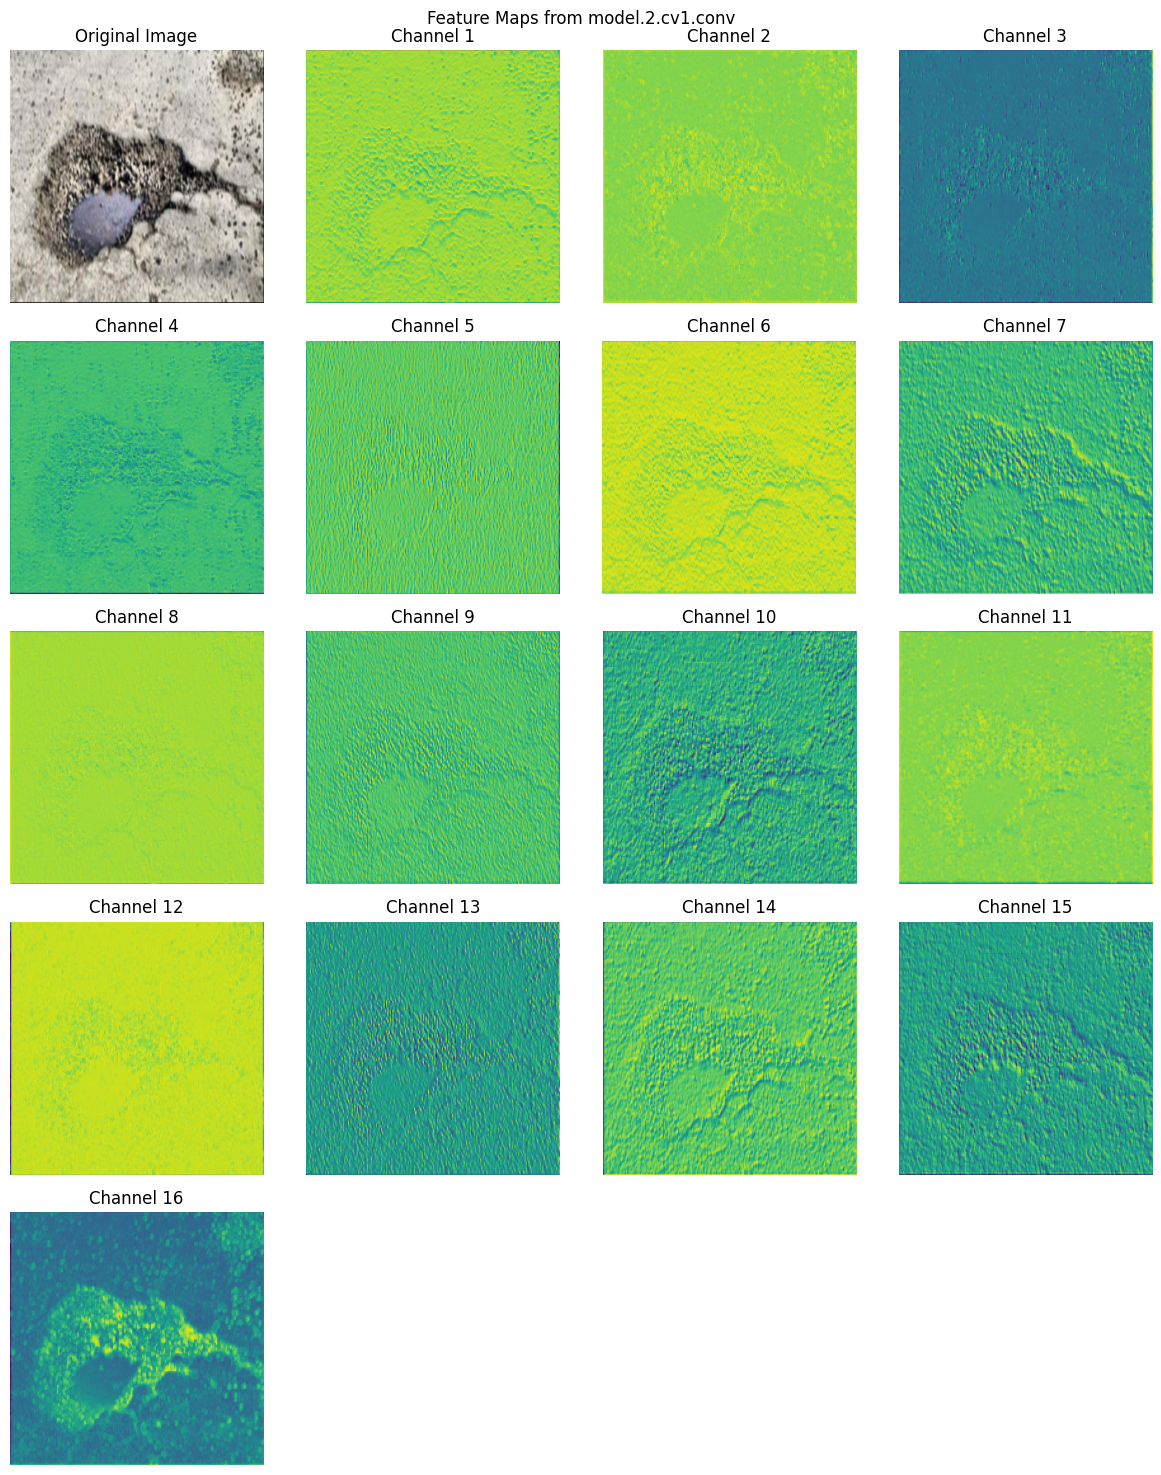

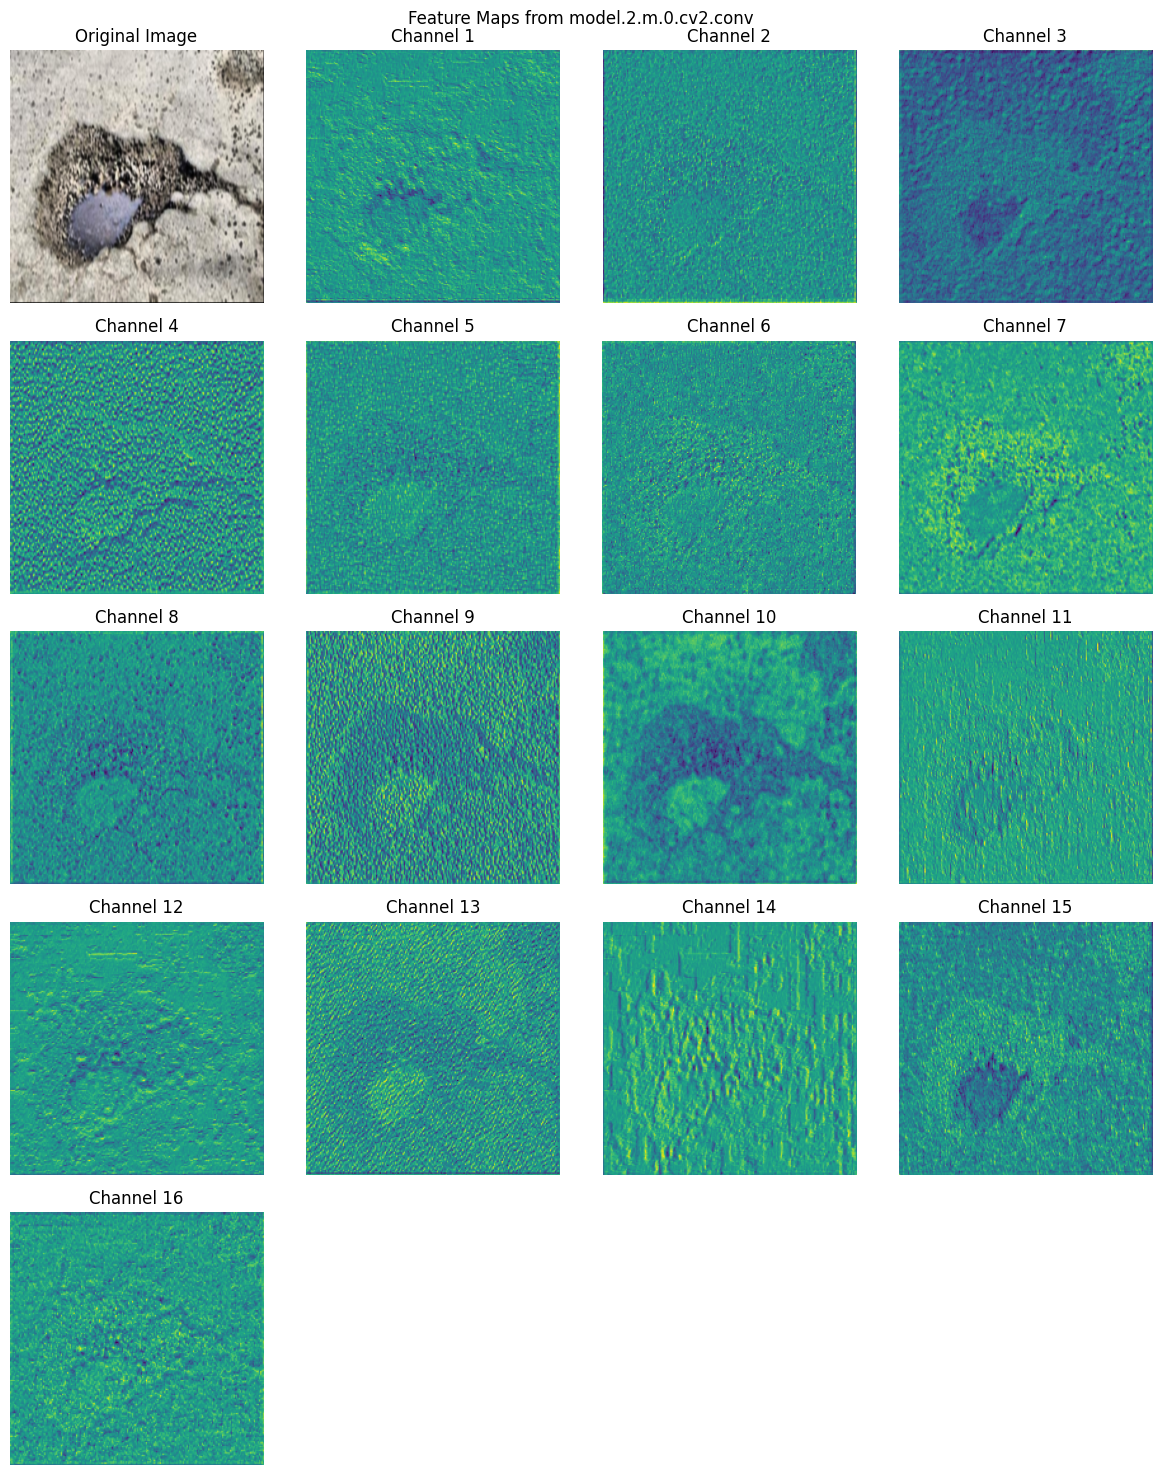

New https://pypi.org/project/ultralytics/8.3.112 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.93 🚀 Python-3.11.12 torch-2.5.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/newPothole/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=800, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/newPothole, name=pothole_training3, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None,

100%|██████████| 755k/755k [00:00<00:00, 22.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.3MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/newPothole/yolo_train... 473 images, 0 backgrounds, 0 corrupt: 100%|██████████| 473/473 [00:07<00:00, 61.56it/s] 


train: New cache created: /content/drive/MyDrive/newPothole/yolo_train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/newPothole/yolo_val... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:02<00:00, 42.51it/s]

val: New cache created: /content/drive/MyDrive/newPothole/yolo_val.cache


Plotting labels to /content/drive/MyDrive/newPothole/pothole_training3/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/newPothole/pothole_training3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.3G      1.819      3.108      2.085          2        800: 100%|██████████| 60/60 [01:01<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        101        235      0.335      0.315      0.239      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.7G      1.502      2.145      1.747          2        800: 100%|██████████| 60/60 [01:02<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]

                   all        101        235      0.495      0.417      0.379      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.7G      1.387      2.185      1.645          3        800: 100%|██████████| 60/60 [01:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]

                   all        101        235       0.21      0.349      0.191     0.0883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.7G      1.436      2.203      1.566          6        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235      0.445      0.409      0.306      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.7G      1.449      1.806      1.591          6        800: 100%|██████████| 60/60 [01:06<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.467      0.391      0.356      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.7G      1.487       1.71      1.591          4        800: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.456      0.489      0.448      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.7G       1.49      1.652      1.608          5        800: 100%|██████████| 60/60 [01:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235      0.421      0.494      0.397      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.7G      1.461      1.576      1.559          3        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]

                   all        101        235      0.641       0.54      0.593      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.7G       1.45      1.491      1.617          1        800: 100%|██████████| 60/60 [01:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.591      0.553      0.565      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.7G      1.447      1.493      1.611          7        800: 100%|██████████| 60/60 [01:08<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235      0.592      0.549       0.56      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.7G      1.457      1.528      1.677          1        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235      0.589      0.507       0.53      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.7G      1.397       1.41      1.586          1        800: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.671      0.404      0.495      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.7G      1.406      1.343      1.581          3        800: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.645      0.557      0.617      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.7G      1.388      1.386      1.582          6        800: 100%|██████████| 60/60 [01:08<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.698      0.596      0.664      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.7G      1.378      1.367      1.567          7        800: 100%|██████████| 60/60 [01:10<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235      0.678      0.566      0.649      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.7G      1.351      1.318      1.522          9        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235       0.66      0.583       0.63      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.7G      1.354      1.335      1.548          1        800: 100%|██████████| 60/60 [01:06<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

                   all        101        235      0.685      0.666      0.679        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.7G      1.347      1.236      1.526         14        800: 100%|██████████| 60/60 [01:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.743      0.604      0.686        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.7G      1.301      1.203      1.502          4        800: 100%|██████████| 60/60 [01:09<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235      0.737      0.626      0.712      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.7G      1.263      1.145      1.487          5        800: 100%|██████████| 60/60 [01:10<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.743      0.613      0.681      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.7G      1.287      1.154      1.492          4        800: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.758      0.613      0.675      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.7G       1.33       1.15      1.503          3        800: 100%|██████████| 60/60 [01:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.758      0.545      0.682      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.7G      1.259      1.124      1.452          5        800: 100%|██████████| 60/60 [01:07<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235      0.679      0.622      0.674      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.7G      1.245      1.084      1.439          3        800: 100%|██████████| 60/60 [01:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]

                   all        101        235      0.725      0.617      0.687      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.7G      1.232      1.099      1.436          1        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]

                   all        101        235      0.777      0.626      0.723      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.7G      1.197      1.034      1.413          2        800: 100%|██████████| 60/60 [01:08<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235       0.73      0.638       0.71      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.7G      1.217     0.9674      1.437          3        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        101        235       0.76      0.632      0.718      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.7G      1.178     0.9866      1.422          2        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235      0.795       0.63      0.746      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.7G      1.176     0.9734      1.417          3        800: 100%|██████████| 60/60 [01:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]

                   all        101        235      0.713       0.66      0.731      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.7G      1.187     0.9782      1.384          5        800: 100%|██████████| 60/60 [01:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235       0.83      0.625      0.745      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.7G      1.158     0.9711      1.403          6        800: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.763      0.651      0.744       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.7G      1.128      1.058      1.363          0        800: 100%|██████████| 60/60 [01:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.767      0.646       0.73      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.7G      1.116     0.8773      1.358          3        800: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235      0.761      0.668      0.749      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.7G      1.131     0.8599      1.373          1        800: 100%|██████████| 60/60 [01:09<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.703      0.685      0.718      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.7G      1.091     0.8413      1.337          4        800: 100%|██████████| 60/60 [01:06<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        101        235      0.755      0.681      0.755      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.7G      1.056     0.8455      1.328          1        800: 100%|██████████| 60/60 [01:09<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.767      0.668      0.742      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.7G      1.063     0.8152       1.34          3        800: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.761       0.69      0.757      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.7G      1.058     0.8042      1.318          4        800: 100%|██████████| 60/60 [01:07<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235      0.794      0.668      0.768      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.7G      1.029      0.763       1.31          1        800: 100%|██████████| 60/60 [01:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.799      0.672      0.773      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.7G      1.006     0.7109      1.294          1        800: 100%|██████████| 60/60 [01:09<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        101        235      0.847      0.589      0.752      0.481


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.7G     0.9767     0.6983      1.264          2        800: 100%|██████████| 60/60 [01:06<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235      0.775      0.694      0.766      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.7G     0.9393      0.639      1.237          3        800: 100%|██████████| 60/60 [01:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235      0.741      0.711      0.771      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.7G     0.9229     0.6142      1.227          2        800: 100%|██████████| 60/60 [01:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.741      0.669      0.755      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.7G     0.9082     0.6068      1.238          3        800: 100%|██████████| 60/60 [01:09<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        101        235      0.778      0.656      0.769      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.7G     0.8799     0.5785      1.213          1        800: 100%|██████████| 60/60 [01:09<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.769       0.66      0.772      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.7G     0.8957      0.563      1.199          1        800: 100%|██████████| 60/60 [01:09<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]

                   all        101        235      0.796      0.651      0.763       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.7G     0.8476     0.5589      1.185          1        800: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        101        235      0.709      0.694      0.762      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.7G     0.8456     0.5172      1.167          1        800: 100%|██████████| 60/60 [01:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.803      0.643      0.765      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.7G     0.8385     0.4989      1.178          1        800: 100%|██████████| 60/60 [01:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        101        235      0.821      0.643      0.769      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.7G     0.8358     0.5223      1.154          5        800: 100%|██████████| 60/60 [01:06<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        101        235       0.78      0.668      0.757        0.5



50 epochs completed in 1.038 hours.
Optimizer stripped from /content/drive/MyDrive/newPothole/pothole_training3/weights/last.pt, 136.7MB
Optimizer stripped from /content/drive/MyDrive/newPothole/pothole_training3/weights/best.pt, 136.7MB

Validating /content/drive/MyDrive/newPothole/pothole_training3/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.11.12 torch-2.5.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


                   all        101        235      0.768       0.66      0.772      0.517
Speed: 0.9ms preprocess, 42.1ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /content/drive/MyDrive/newPothole/pothole_training3
Ultralytics 8.3.93 🚀 Python-3.11.12 torch-2.5.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/drive/MyDrive/newPothole/yolo_val.cache... 101 images, 0 backgrounds, 0 corrupt: 100%|██████████| 101/101 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.09s/it]


                   all        101        235       0.77       0.66      0.772      0.518
Speed: 6.6ms preprocess, 123.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/drive/MyDrive/newPothole/pothole_training32
mAP@0.5: 0.7718
mAP@0.5:0.95: 0.5183


In [ ]:
# Uninstall any existing packages to start fresh
!pip uninstall -y torch torchvision torchaudio ultralytics

# Install stable Ultralytics and CUDA 12.4 compatible PyTorch
!pip install ultralytics==8.3.93
!pip install \
  torch==2.5.0 \
  torchvision==0.20.0 \
  torchaudio==2.5.0 \
  -f https://download.pytorch.org/whl/cu124/torch_stable.html \
  --no-cache-dir

# Note: After running the above installations, restart the runtime in Colab:
# Click Runtime -> Restart Runtime, then rerun all cells.
# Alternatively, add the following line if programmatic restart is supported:
# import os; os._exit(00)

import os
import shutil
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import transforms

# Verify PyTorch and GPU setup
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

# Define paths
base_path = '/content/drive/MyDrive/newPothole'
output_base_path = os.path.join(base_path, 'processed_dataset_new')
yolo_train_dir = os.path.join(base_path, 'yolo_train')
yolo_val_dir = os.path.join(base_path, 'yolo_val')
weights_dir = os.path.join(base_path, 'pothole_training/weights')

# Copy files with matching names
def copy_to_yolo_folders():
    for subset in ['train', 'val']:
        src_image_dir = os.path.join(output_base_path, f'warped_images/{subset}')
        src_label_dir = os.path.join(output_base_path, f'warped_labels/{subset}')
        dest_dir = yolo_train_dir if subset == 'train' else yolo_val_dir

        # Check if source directories exist
        if not os.path.exists(src_image_dir):
            raise FileNotFoundError(f"Source image directory {src_image_dir} does not exist")
        if not os.path.exists(src_label_dir):
            raise FileNotFoundError(f"Source label directory {src_label_dir} does not exist")

        os.makedirs(dest_dir, exist_ok=True)

        # Copy images
        image_count = 0
        for image_file in os.listdir(src_image_dir):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                shutil.copy2(os.path.join(src_image_dir, image_file), os.path.join(dest_dir, image_file))
                image_count += 1

        # Copy labels
        label_count = 0
        for label_file in os.listdir(src_label_dir):
            if label_file.endswith('.txt'):
                new_label_file = f"warped_{label_file}"
                shutil.copy2(os.path.join(src_label_dir, label_file), os.path.join(dest_dir, new_label_file))
                label_count += 1

        print(f"Copied {image_count} {subset} images and {label_count} labels to {dest_dir}")

# Always run copy to ensure directories are populated
copy_to_yolo_folders()

# Configure data.yaml
data_yaml = f"""
train: {yolo_train_dir}
val: {yolo_val_dir}
nc: 1
names: ['pothole']
"""
data_yaml_path = os.path.join(base_path, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml)

# Load model: Always start fresh with yolov8x.pt
print("Starting fresh training with yolov8x.pt")
model = YOLO('yolov8x.pt')

# Use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}")

# Function to visualize feature maps with original image
def visualize_feature_maps(feature_maps, layer_name, original_img, num_channels=16):
    feature_maps = feature_maps.squeeze(0).cpu().detach().numpy()  # Shape: [C, H, W]
    num_channels = min(num_channels, feature_maps.shape[0])

    # Create a grid of feature maps, including space for original image
    total_plots = num_channels + 1  # +1 for original image
    cols = 4
    rows = int(np.ceil(total_plots / cols))
    plt.figure(figsize=(12, 3 * rows))

    # Plot original image in the first subplot
    plt.subplot(rows, cols, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot feature maps
    for i in range(num_channels):
        plt.subplot(rows, cols, i + 2)  # Start from second subplot
        feature_map = feature_maps[i]
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-8)  # Normalize
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f'Channel {i+1}')
        plt.axis('off')
    plt.suptitle(f'Feature Maps from {layer_name}')
    plt.tight_layout()
    plt.show()

# Hook to capture intermediate feature maps
feature_maps = {}
def hook_fn(module, input, output, layer_name):
    feature_maps[layer_name] = output

# Register hooks for two important layers
model.model.eval()  # Set to eval to inspect architecture
model_module = model.model
model_module.to(device)  # Move model to the same device as input
layer_names = []
for name, module in model_module.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        layer_names.append(name)

# Select two important layers (e.g., early and mid-level conv layers)
selected_layers = [layer_names[2], layer_names[5]]  # Adjust indices based on model architecture
hooks = []
for layer_name in selected_layers:
    layer = dict(model_module.named_modules())[layer_name]
    hooks.append(layer.register_forward_hook(lambda m, i, o, ln=layer_name: hook_fn(m, i, o, ln)))

# Load a sample image
sample_image_path = os.path.join(yolo_train_dir, os.listdir(yolo_train_dir)[0])
img = cv2.imread(sample_image_path)
if img is None:
    raise FileNotFoundError(f"Sample image not found at {sample_image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

# Run a forward pass to capture feature maps
model.model.eval()
with torch.no_grad():
    _ = model.model(img_tensor)
for layer_name in selected_layers:
    visualize_feature_maps(feature_maps[layer_name], layer_name, original_img=img)

# Remove hooks
for hook in hooks:
    hook.remove()

# Train using SGD optimizer with augmentation
model.model.train()  # Set back to train mode
model.train(
    data=data_yaml_path,
    epochs=50,
    batch=8,
    imgsz=800,
    optimizer='SGD',
    lr0=0.01,
    project=base_path,
    name='pothole_training',
    exist_ok=False,
    device=device,
    verbose=True,
    hsv_h=0.015,  # Augmentation: Hue
    hsv_s=0.7,    # Augmentation: Saturation
    hsv_v=0.4,    # Augmentation: Value
    flipud=0.5    # Augmentation: Vertical flip
)

# Validate and print accuracy
val_results = model.val()
print(f"mAP@0.5: {val_results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {val_results.box.map:.4f}")

Cell 8: Step 7 - Save Model

In [ ]:
import os
import shutil

# Define paths
base_path = '/content/drive/MyDrive/newPothole'
best_model_path = os.path.join(base_path, 'pothole_training3/weights/best.pt')
saved_model_path = os.path.join(base_path, 'yolov8_best.pt')

# Save model
if os.path.exists(best_model_path):
    shutil.copy2(best_model_path, saved_model_path)
    print(f"Saved trained model to {saved_model_path}")
else:
    print(f"Warning: Best model not found at {best_model_path}. Training may have failed.")

Saved trained model to /content/drive/MyDrive/newPothole/yolov8_best.pt


Step 7 (Original Step 8): test

In [ ]:
import os
!pip install ultralytics==8.3.93

import cv2
from ultralytics import YOLO

# Define paths
base_path = '/content/drive/MyDrive/newPothole'
pp= '/content/drive/MyDrive/Sem 6/Pothole'
test_images_dir = os.path.join(pp, 'DiverseDataset')
results_dir = os.path.join(base_path, 'results')
model_path = os.path.join(base_path, 'yolov8_best.pt')

# Create results directory
os.makedirs(results_dir, exist_ok=True)

# Load the trained model
model = YOLO(model_path)

# Test the model on test images
image_extensions = ('.jpg', '.jpeg', '.png')
test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(image_extensions)]

for image_file in test_images:
    image_path = os.path.join(test_images_dir, image_file)
    output_path = os.path.join(results_dir, f"bounded_{image_file}")

    # Run inference
    results = model.predict(image_path, imgsz=800, device='cpu')

    # Draw bounding boxes on the image
    img = cv2.imread(image_path)
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            conf = box.conf[0]  # Confidence score
            label = f"pothole {conf:.2f}"
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save the bounded image
    cv2.imwrite(output_path, img)
    print(f"Saved bounded image to {output_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal